## <font color='#2F4F4F'>1. Defining the Question</font>

### a) Specifying the Data Analysis Question

Perform multiple regression models to predict the number of taxi orders for the next hour.

### b) Defining the Metric for Success

The project will be a success when we are able to create a regression model with an RMSE that is not more than 48

### c) Understanding the Context 

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more
drivers during peak hours, we need to predict the number of taxi orders for the next hour. Build a
model for such a prediction.

### d) Recording the Experimental Design

1. Load datasets and libraries
2. Clean data
3. Perform univariate and bivariate analysis
4. Check that the assumptions of multiple linear regression aren't violated
5. Perform multiple linear regression
6. Summarize findings
7. Provide recommendations
8. Challenge the solution

### e) Data Relevance

The dataset provided is appropriate and relevant to the research question.

# <font color='#2F4F4F'>2. Data Cleaning & Preparation</font>

### a) Import Prerequisite Libraries

In [1]:
# loading base libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose

# models
from sklearn.svm import SVR 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor  
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# splitting the data
from sklearn.model_selection import train_test_split
# normalization
from sklearn.preprocessing import MinMaxScaler
# standardization
from sklearn.preprocessing import StandardScaler 

# scoring metrics
from sklearn.metrics import mean_squared_error

pd.set_option('display.max.columns', None)
pd.set_option('display.max_colwidth', None)
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### b) Load the data

In [2]:
# loading and previewing dataset
data = pd.read_csv('https://bit.ly/3p1QPAv')
print(data.shape)
data.head()

(26496, 2)


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


### c) Data Preparation

In [3]:
# check the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
# convert the datetime column from object to datetime
data['datetime'] = pd.to_datetime(data['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [5]:
# Set the table index equal to the Datetime column
data.set_index('datetime',inplace=True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
# check for the range of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


The data is from 01 March 2018 to 31 August 2018, we shall confirm

In [7]:
# check if the dates and times are in chronological order
data.index.is_monotonic

True

The data is already sorted in a chronological order. <br>
So it is true it ranges from 01 March 2018 to 31 August 2018

In [8]:
# sort the index column just in case
data.sort_index(inplace=True)
data.index.is_monotonic

True

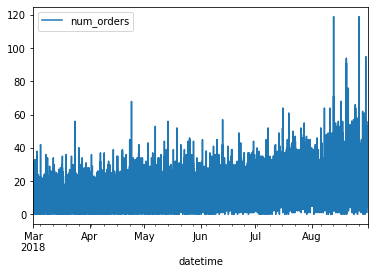

In [9]:
# plot the data
data.plot();

the graph is a bit clustered, we shall resample to 1 Hour

# <font color='#2F4F4F'>3. Data Analysis</font>

### a) Data Resampling

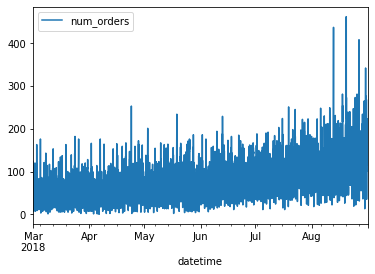

In [10]:
data = data.resample('1H').sum()
data.plot();

The graph shows a signal, to check for trends across the entire period let's plot per day

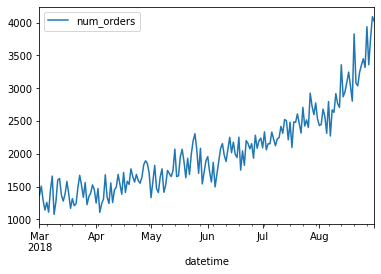

In [11]:
day_data = data.resample('1D').sum()
day_data.plot();

The graph shows an upward trajectory with orders increasing from March to August

To check for trends per hour we shall plot using data for a week only

In [12]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


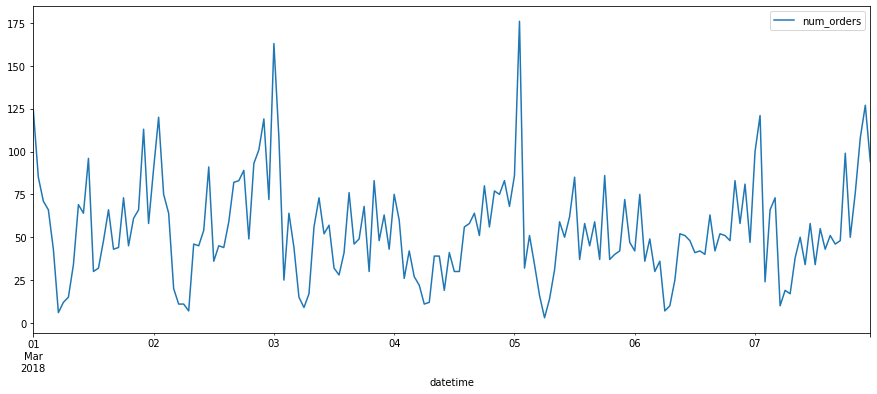

In [13]:
data_week = data['2018-03-01':'2018-03-07']
data_week.plot(figsize=(15,6));

The graph shows a decline in orders from midnight to morning (around 6 am). Afterwards the orders tend to fluctuate but mostly peak at midnight

### b) Rolling Mean

The rolling mean helps to understand on average how the orders are moving

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



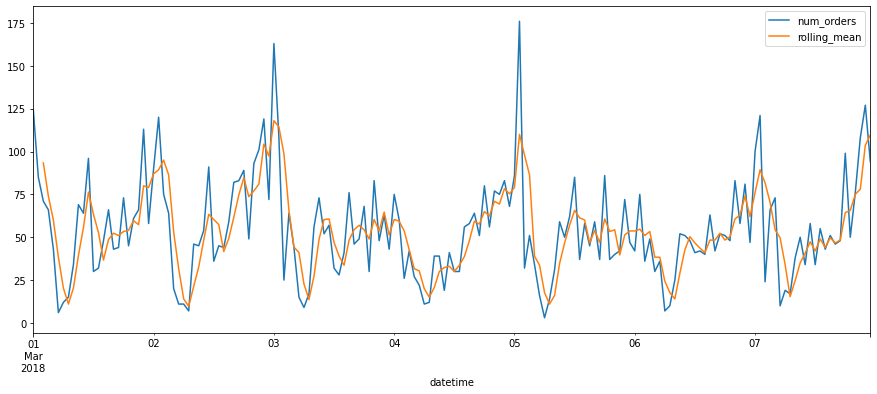

In [14]:
# let's plot a rolling mean for 3 hours
data_week['rolling_mean'] = data_week.rolling(3).mean()
data_week.plot(figsize=(15,6));

The rolling mean shows a similar trend as the number of orders

### c) Trends and Seasonality

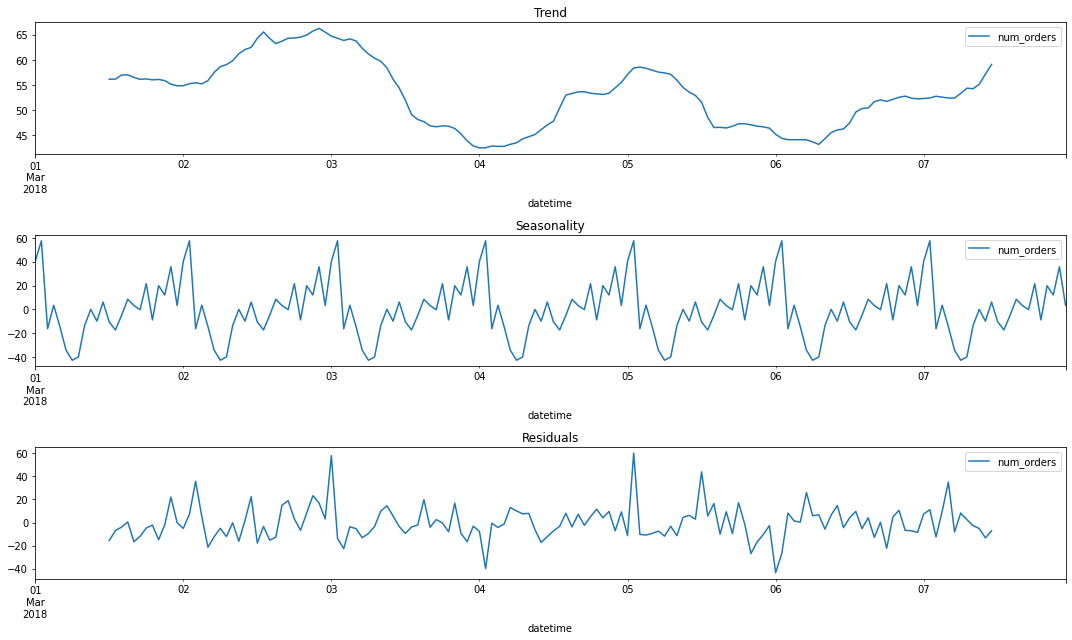

In [15]:
data_week = data['2018-03-01':'2018-03-07']
decomposed = seasonal_decompose(data_week) 

plt.figure(figsize=(15,9))
plt.subplot(311)
# To display the graph correctly, specify its
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
# < write code here >
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
# < write code here >
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Seasonality graph shows the same deep in the number of orders during morning hours

# <font color='#2F4F4F'>4. Data Modeling</font>

### a) Creating Features

In [16]:
# Calendar features
# trends and seasonality are linked to a specific date and/or hour
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour
data.head()

,num_orders,month,day,dayofweek,hour
datetime,,,,,
2018-03-01 00:00:00,124,3,1,3,0
2018-03-01 01:00:00,85,3,1,3,1
2018-03-01 02:00:00,71,3,1,3,2
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,3,4


In [17]:
# Lag features
# The previous values in the time series will tell you whether there is an increase or decrease
# let's create previous value for each hour
data['previous_hour'] = data['num_orders'].shift(1)
data.head()

,num_orders,month,day,dayofweek,hour,previous_hour
datetime,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0
2018-03-01 02:00:00,71,3,1,3,2,85.0
2018-03-01 03:00:00,66,3,1,3,3,71.0
2018-03-01 04:00:00,43,3,1,3,4,66.0


In [18]:
# Rolling mean
# The rolling mean feature sets the general trend of the time series
data['rolling_mean'] = data['num_orders'].rolling(2).mean()
data.head()

,num_orders,month,day,dayofweek,hour,previous_hour,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,104.5
2018-03-01 02:00:00,71,3,1,3,2,85.0,78.0
2018-03-01 03:00:00,66,3,1,3,3,71.0,68.5
2018-03-01 04:00:00,43,3,1,3,4,66.0,54.5


### b) Data Splitting

In [19]:
# remove null values
data.dropna(axis=0,inplace=True)
X = data.drop('num_orders',axis=1)
y = data['num_orders']

# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1, random_state=0)
print('\nX_train: ', X_train.shape, '\nX_test: ',X_test.shape, '\ny_train: ',y_train.shape, '\ny_test: ',y_test.shape)


X_train:  (3973, 6) 
X_test:  (442, 6) 
y_train:  (3973,) 
y_test:  (442,)


### c) Model Training and Predictions

In [20]:
# initializing our models   
svm_regressor = SVR(kernel='rbf', C=10)
knn_regressor = KNeighborsRegressor()
dec_regressor = DecisionTreeRegressor(random_state=0)
rf_regressor = RandomForestRegressor(random_state=0)
lr_regressor = LinearRegression()

# Fitting in our models  
svm_regressor.fit(X_train, y_train)
knn_regressor.fit(X_train, y_train)
dec_regressor.fit(X_train, y_train)
rf_regressor.fit(X_train, y_train)
lr_regressor.fit(X_train, y_train)

# Making Predictions  
svm_y_pred = svm_regressor.predict(X_test)
knn_y_pred = knn_regressor.predict(X_test)
dec_y_pred = dec_regressor.predict(X_test)
rf_y_pred = rf_regressor.predict(X_test)
lr_y_pred = lr_regressor.predict(X_test)

# Finally, evaluating our models  
print('SVM RMSE:', np.sqrt(mean_squared_error(y_test, svm_y_pred)))
print('KNN RMSE:', np.sqrt(mean_squared_error(y_test, knn_y_pred)))
print('Decision Tree RMSE:', np.sqrt(mean_squared_error(y_test, dec_y_pred)))
print('Random Forest RMSE:', np.sqrt(mean_squared_error(y_test, rf_y_pred)))
print('Linear Regression RMSE:', np.sqrt(mean_squared_error(y_test, lr_y_pred)))

SVM RMSE: 29.978450108868984
KNN RMSE: 19.846255217391672
Decision Tree RMSE: 24.096149783505666
Random Forest RMSE: 19.644216458578672
Linear Regression RMSE: 1.730108858890475e-13


<i>The best model was the Linear regression model with an RMSE less than 1

In [21]:
test_data = X_test
test_data['num_orders'] = y_test
test_data['pred_orders'] = lr_y_pred
test_data.head()

,month,day,dayofweek,hour,previous_hour,rolling_mean,num_orders,pred_orders
datetime,,,,,,,,
2018-08-13 14:00:00,8,13,0,14,119.0,110.5,102,102.0
2018-08-13 15:00:00,8,13,0,15,102.0,138.5,175,175.0
2018-08-13 16:00:00,8,13,0,16,175.0,159.5,144,144.0
2018-08-13 17:00:00,8,13,0,17,144.0,148.0,152,152.0
2018-08-13 18:00:00,8,13,0,18,152.0,128.0,104,104.0


In [22]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          442 non-null    int64  
 1   day            442 non-null    int64  
 2   dayofweek      442 non-null    int64  
 3   hour           442 non-null    int64  
 4   previous_hour  442 non-null    float64
 5   rolling_mean   442 non-null    float64
 6   num_orders     442 non-null    int64  
 7   pred_orders    442 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 31.1 KB


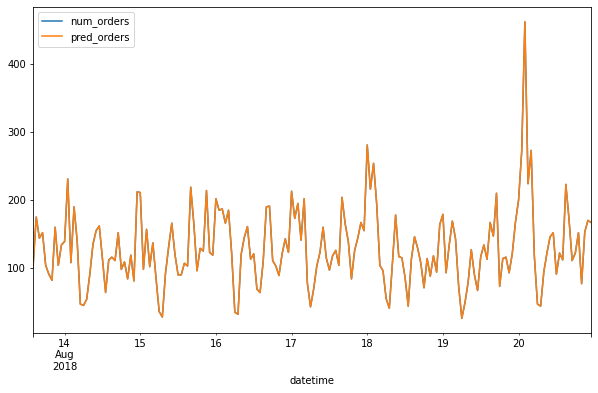

In [23]:
test_data['2018-08-13':'2018-08-20'][['num_orders','pred_orders']].plot(figsize=(10,6));

<i> From the above graphs it's evident the Linear Regression model accurately predicted the number of orders per hour

# <font color='#2F4F4F'>5. Summary of Findings</font>

A linear regression model was the best model that can be used to predict the number of orders

# <font color='#2F4F4F'>6. Recommendations</font>

To attract more drivers during peak hours, Sweet Lift Taxi company can rely on the Linear Regression model to predict the number of orders for each hour

# <font color='#2F4F4F'>7. Challenging your Solution</font>

#### a) Did we have the right question?
Yes.

#### b) Did we have the right data?
Yes.

#### c) What can be done to improve the solution?
With an RMSE of less than 1 our model needs no further improvements